### Task 1: Baseline Evaluation

In [1]:
# Manually upload the TestDataSet.zip file
from google.colab import files
uploaded = files.upload()

Saving TestDataSet.zip to TestDataSet.zip


In [2]:
import zipfile
import os

zip_path = "TestDataSet.zip"
extract_path = "/content"

# unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("TestDataSet extracted successfully.")

TestDataSet extracted successfully.


In [3]:
import os
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import urllib.request
import time
import matplotlib.pyplot as plt

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import json

# Load label list from JSON file
with open('/content/TestDataSet/labels_list.json', 'r') as f:
    label_list = json.load(f)

# Convert list like "401: accordion" to dict: {401: "accordion", ...}
idx_to_label = {}
for item in label_list:
    parts = item.split(":")
    if len(parts) == 2:
        index = int(parts[0].strip())
        name = parts[1].strip()
        idx_to_label[index] = name

print(f"Loaded {len(idx_to_label)} class labels from JSON.")

Loaded 100 class labels from JSON.


In [5]:
# ImageNet normalization values
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define image transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Path to your test dataset folder (provided by instructor)
# Update correct path
dataset_path = "/content/TestDataSet"

In [6]:
# Mapping from WordNet ID (WNID) to ImageNet class index
wnid_to_idx = {
    "n02672831": 401, "n02676566": 402, "n02687172": 403, "n02690373": 404, "n02692877": 405,
    "n02699494": 406, "n02701002": 407, "n02704792": 408, "n02708093": 409, "n02727426": 410,
    "n02730930": 411, "n02747177": 412, "n02749479": 413, "n02769748": 414, "n02776631": 415,
    "n02777292": 416, "n02782093": 417, "n02783161": 418, "n02786058": 419, "n02787622": 420,
    "n02788148": 421, "n02790996": 422, "n02791124": 423, "n02791270": 424, "n02793495": 425,
    "n02794156": 426, "n02795169": 427, "n02797295": 428, "n02799071": 429, "n02802426": 430,
    "n02804414": 431, "n02804610": 432, "n02807133": 433, "n02808304": 434, "n02808440": 435,
    "n02814533": 436, "n02814860": 437, "n02815834": 438, "n02817516": 439, "n02823428": 440,
    "n02823750": 441, "n02825657": 442, "n02834397": 443, "n02835271": 444, "n02837789": 445,
    "n02840245": 446, "n02841315": 447, "n02843684": 448, "n02859443": 449, "n02860847": 450,
    "n02865351": 451, "n02869837": 452, "n02870880": 453, "n02871525": 454, "n02877765": 455,
    "n02879718": 456, "n02883205": 457, "n02892201": 458, "n02892767": 459, "n02894605": 460,
    "n02895154": 461, "n02906734": 462, "n02909870": 463, "n02910353": 464, "n02916936": 465,
    "n02917067": 466, "n02927161": 467, "n02930766": 468, "n02939185": 469, "n02948072": 470,
    "n02950826": 471, "n02951358": 472, "n02951585": 473, "n02963159": 474, "n02965783": 475,
    "n02966193": 476, "n02966687": 477, "n02971356": 478, "n02974003": 479, "n02977058": 480,
    "n02978881": 481, "n02979186": 482, "n02980441": 483, "n02981792": 484, "n02988304": 485,
    "n02992211": 486, "n02992529": 487, "n02999410": 488, "n03000134": 489, "n03000247": 490,
    "n03000684": 491, "n03014705": 492, "n03016953": 493, "n03017168": 494, "n03018349": 495,
    "n03026506": 496, "n03028079": 497, "n03032252": 498, "n03041632": 499, "n03045698": 500, "n03042490": 501
}

In [7]:
class ImageNetSubsetDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.transform = transform

        for wnid in os.listdir(root):
            folder_path = os.path.join(root, wnid)
            if not os.path.isdir(folder_path):
                continue
            label_idx = wnid_to_idx.get(wnid)
            if label_idx is None:
                continue
            for fname in os.listdir(folder_path):
                if fname.endswith('.JPEG'):
                    full_path = os.path.join(folder_path, fname)
                    self.samples.append((full_path, label_idx))

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.samples)

In [8]:
# Load the test dataset
test_dataset = ImageNetSubsetDataset(root=dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=False)

print(f"Loaded {len(test_dataset)} test images.")

# Load pretrained model
model = models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()


Loaded 500 test images.


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 182MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Compute top-k accuracy
def topk_accuracy(output, target, topk=(1, 5)):
    maxk = max(topk)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k)
    return res

In [10]:
# Evaluate on the test set
top1_total, top5_total, total = 0, 0, 0

start = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        t1, t5 = topk_accuracy(outputs, labels, topk=(1, 5))
        top1_total += t1.item()
        top5_total += t5.item()
        total += labels.size(0)
end = time.time()
# Report accuracy
top1_acc = top1_total / total
top5_acc = top5_total / total

print(f"Evaluation took {end - start:.2f} seconds")
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")

Evaluation took 2.90 seconds
Top-1 Accuracy: 0.7560
Top-5 Accuracy: 0.9360


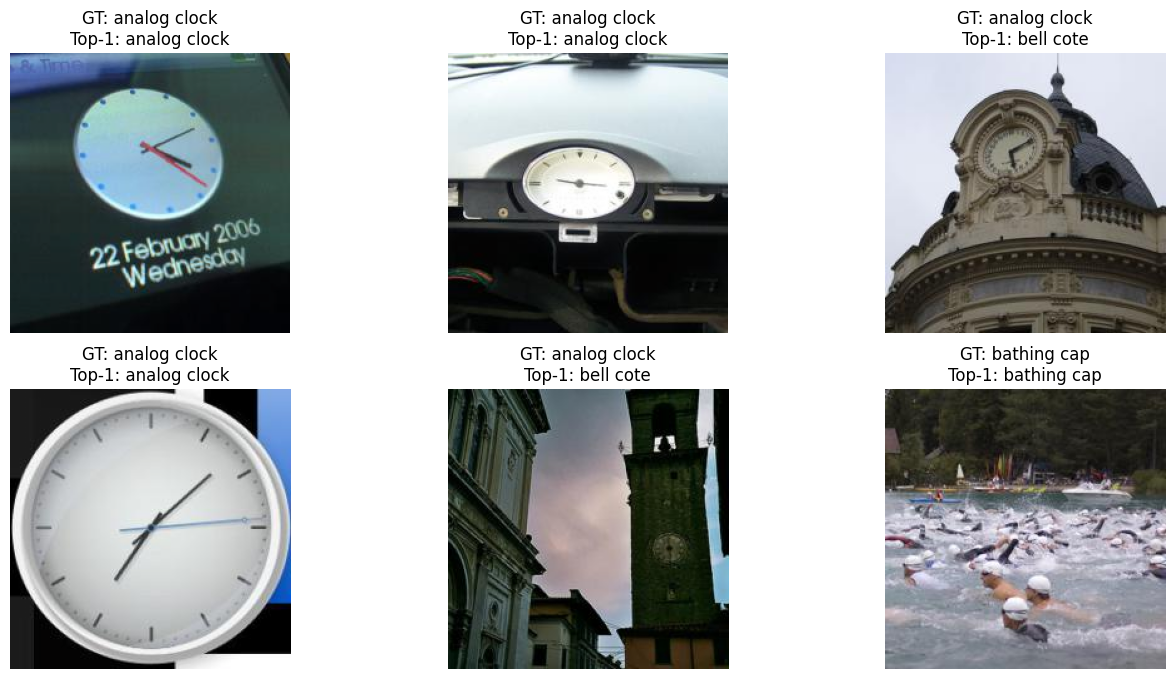

In [11]:
# Inverse normalization function
def denormalize(img_tensor):
    mean = torch.tensor(mean_norms).view(3,1,1)
    std = torch.tensor(std_norms).view(3,1,1)
    return img_tensor * std + mean


# Visualize model predictions for a batch
def visualize_predictions():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = outputs.topk(5, 1, True, True)

    plt.figure(figsize=(16, 8))
    for i in range(6):
        img = denormalize(images[i].cpu()).permute(1, 2, 0).numpy()
        gt = idx_to_label.get(labels[i].item(), "Unknown")
        pred = [idx_to_label.get(p.item(), "?") for p in preds[i]]

        plt.subplot(2, 3, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
        plt.title(f"GT: {gt}\nTop-1: {pred[0]}")
    plt.show()

# Call visualization
visualize_predictions()

### Task 2: Pixel-wise attacks

In [12]:
# FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    # Get the sign of the gradients
    sign_data_grad = data_grad.sign()
    # Perturb the image by a small step in the gradient direction
    perturbed_image = image + epsilon * sign_data_grad
    return perturbed_image

In [13]:
# Parameters
import torch.nn.functional as F

epsilon_1 = 0.02
adv_examples = []
adv_images = []
adv_labels = []

model.eval()
total, correct_top1, correct_top5 = 0, 0, 0
orig_images = []
start = time.time()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    orig_images.append(images.detach().cpu())
    images.requires_grad = True

    # Forward pass
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data

    # FGSM attack
    perturbed_data = fgsm_attack(images, epsilon_1, data_grad)

    adv_images.append(perturbed_data.detach().cpu())
    adv_labels.append(labels.detach().cpu())

    # Re-evaluate with perturbed images
    outputs_adv = model(perturbed_data)
    _, pred = outputs_adv.topk(5, 1, True, True)
    correct = pred.eq(labels.view(-1, 1).expand_as(pred))

    correct_top1 += correct[:, :1].sum().item()
    correct_top5 += correct[:, :5].sum().item()
    total += labels.size(0)

end = time.time()

In [14]:
# concate
adv_tensor = torch.cat(adv_images, dim=0)
orig_tensor = torch.cat(orig_images, dim=0)

perturbation = (adv_tensor - orig_tensor).abs()
l_inf = perturbation.view(perturbation.size(0), -1).max(dim=1)[0]

print(f"FGSM L∞ (pixel space): mean = {l_inf.mean():.4f}, max = {l_inf.max():.4f}")

FGSM L∞ (pixel space): mean = 0.0200, max = 0.0200


In [15]:
# Compute top-1 and top-5 accuracy after attack
adv1_top1 = correct_top1 / total
adv1_top5 = correct_top5 / total

print(f"FGSM Attack took {end - start:.2f} seconds")
print(f"ε = {epsilon_1}:")
print(f"FGSM Attack Top-1 Accuracy: {adv1_top1:.4f}")
print(f"FGSM Attack Top-5 Accuracy: {adv1_top5:.4f}")

# Compare with baseline drop
print(f"Accuracy Drop (Top-1): {top1_acc - adv1_top1:.4f}")
print(f"Accuracy Drop (Top-5): {top5_acc - adv1_top5:.4f}")

FGSM Attack took 4.63 seconds
ε = 0.02:
FGSM Attack Top-1 Accuracy: 0.0600
FGSM Attack Top-5 Accuracy: 0.3520
Accuracy Drop (Top-1): 0.6960
Accuracy Drop (Top-5): 0.5840


In [16]:
# Concatenate all adversarial images
adv_images_tensor = torch.cat(adv_images)
adv_labels_tensor = torch.cat(adv_labels)

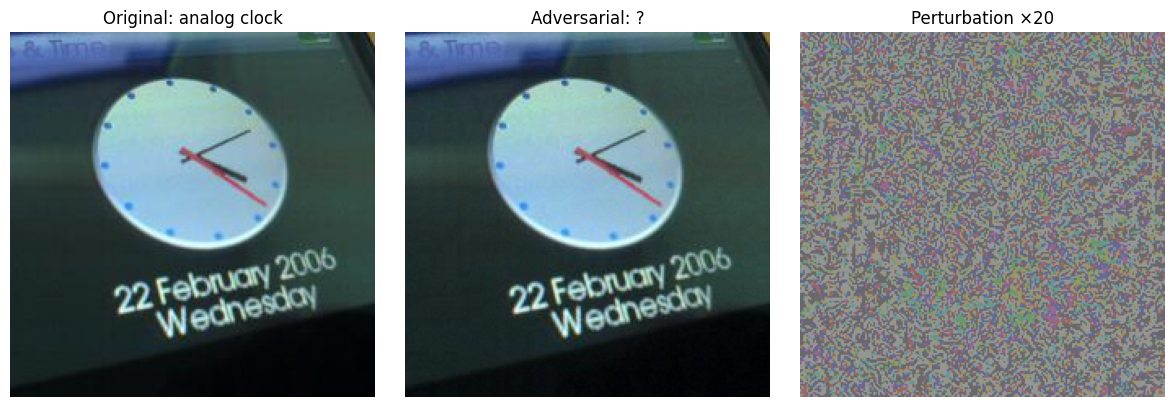

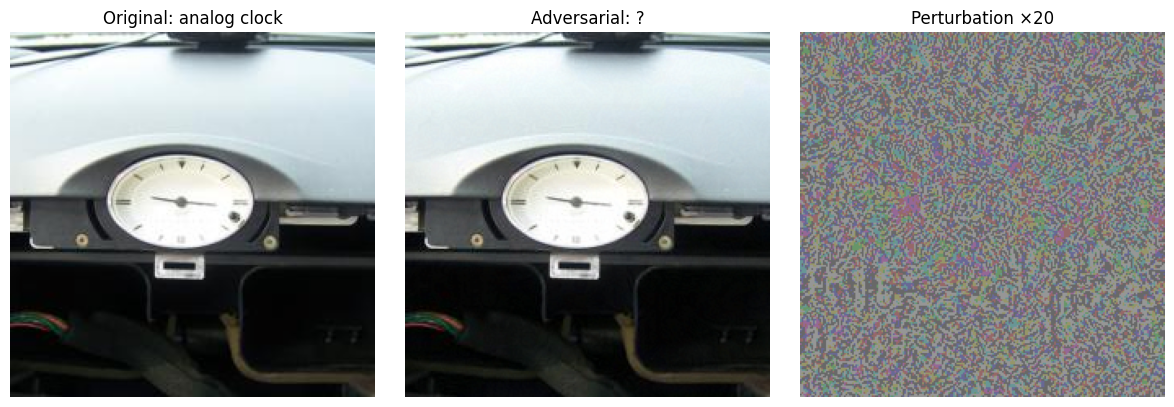

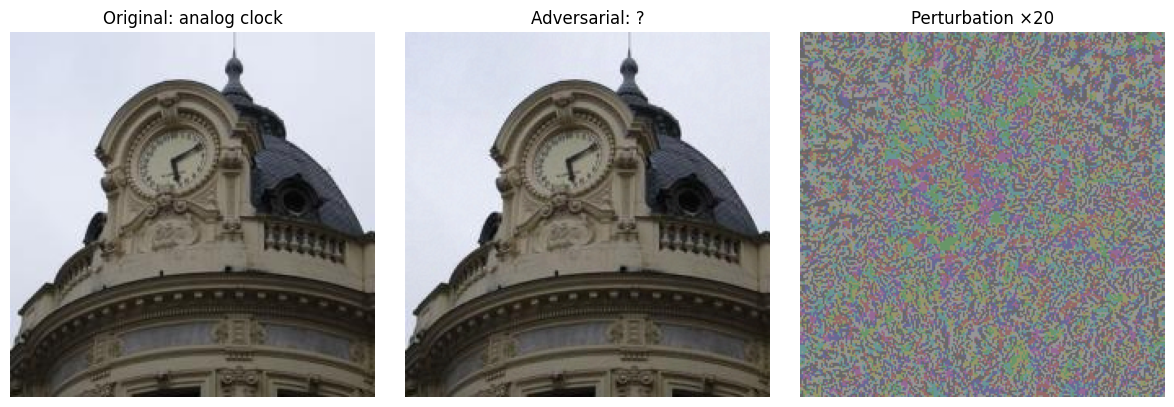

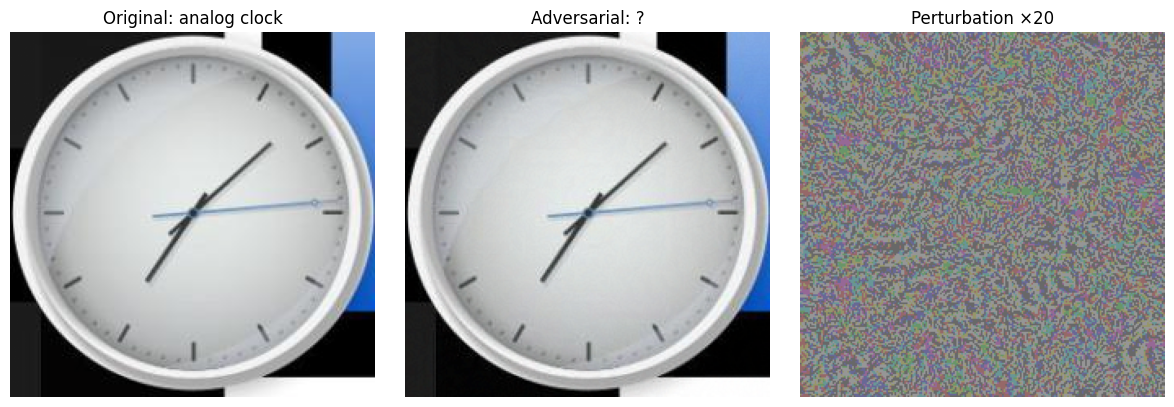

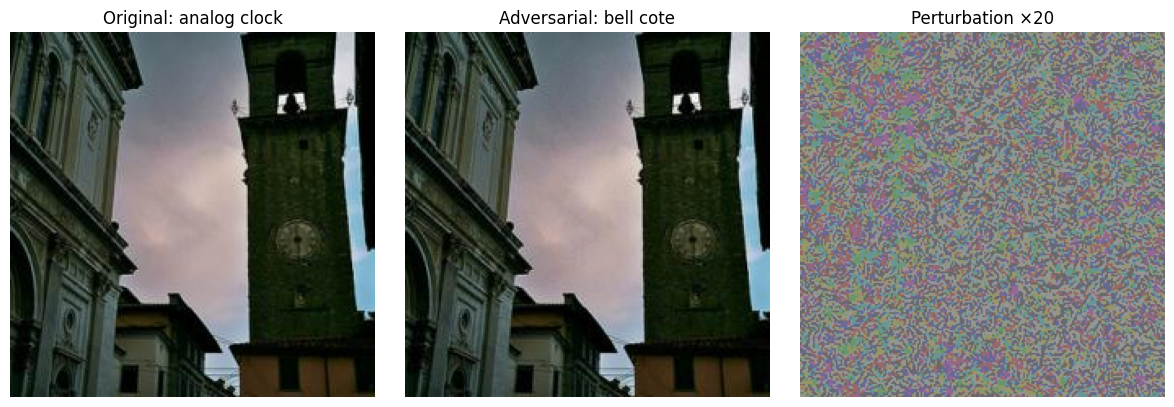

In [17]:
def visualize_adversarial_examples(num=5, amplify=20):
    model.eval()
    count = 0
    for i in range(len(adv_images_tensor)):
        #Get the original and counter images (both normalized)
        orig_norm = test_dataset[i][0]        # tensor, already normalized
        adv_norm = adv_images_tensor[i]       # tensor, normalized

        # Inverse normalization for visualization
        orig = denormalize(orig_norm).permute(1, 2, 0).numpy()
        adv = denormalize(adv_norm).permute(1, 2, 0).numpy()
        perturbation = adv - orig             # Calculate the size of perturbation

        # model prediction
        image_tensor = adv_norm.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = output.max(1)

        pred_label = idx_to_label.get(predicted.item(), "?")
        true_label = idx_to_label.get(adv_labels_tensor[i].item(), "?")

        # Displayed only when the forecast changes
        if pred_label != true_label:
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(np.clip(orig, 0, 1))
            plt.title(f"Original: {true_label}")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(np.clip(adv, 0, 1))
            plt.title(f"Adversarial: {pred_label}")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            pert_vis = np.clip((perturbation * amplify + 0.5), 0, 1)
            plt.imshow(pert_vis)
            plt.title(f"Perturbation ×{amplify}")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            count += 1
            if count >= num:
                break
visualize_adversarial_examples(num=5, amplify=20)

### Task 3: Improved attacks

In [18]:
# PGD Attack Implementation
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    ori_images = images.data

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = images.grad.data

        # Update with small step in gradient direction
        adv_images = images + alpha * grad.sign()

        # Clip to stay within epsilon-ball of original image
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = (ori_images + eta).detach()

    return images

In [19]:
# PGD Parameters
epsilon_2 = 0.02
alpha = 0.005
pgd_iters = 10

# Store perturbed images and labels
adv_images_pgd = []
adv_labels_pgd = []
linf_norms = []

model.eval()
total, correct_top1, correct_top5 = 0, 0, 0
start = time.time()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    original_images = images.clone().detach()

    # Apply PGD attack
    perturbed = pgd_attack(model, images, labels, epsilon_2, alpha, pgd_iters)

    delta = (perturbed - original_images).view(perturbed.size(0), -1)
    linf = delta.abs().max(dim=1)[0]
    linf_norms.append(linf.cpu())

    # Store for visualization or saving
    adv_images_pgd.append(perturbed.detach().cpu())
    adv_labels_pgd.append(labels.detach().cpu())

    # Evaluate
    outputs = model(perturbed)
    _, pred = outputs.topk(5, 1, True, True)
    correct = pred.eq(labels.view(-1, 1).expand_as(pred))
    correct_top1 += correct[:, :1].sum().item()
    correct_top5 += correct[:, :5].sum().item()
    total += labels.size(0)

end = time.time()
print(f"PGD Attack took {end - start:.2f} seconds")

# Perturbation statistics
linf_all = torch.cat(linf_norms)
print(f"Average L∞ perturbation: {linf_all.mean():.6f}")

# Final accuracy
adv2_top1 = correct_top1 / total
adv2_top5 = correct_top5 / total

print(f"PGD Attack Top-1 Accuracy: {adv2_top1:.4f}")
print(f"PGD Attack Top-5 Accuracy: {adv2_top5:.4f}")

PGD Attack took 27.82 seconds
Average L∞ perturbation: 0.020000
PGD Attack Top-1 Accuracy: 0.0000
PGD Attack Top-5 Accuracy: 0.1000


In [20]:
adv_images_pgd_tensor = torch.cat(adv_images_pgd, dim=0)
adv_labels_pgd_tensor = torch.cat(adv_labels_pgd, dim=0)

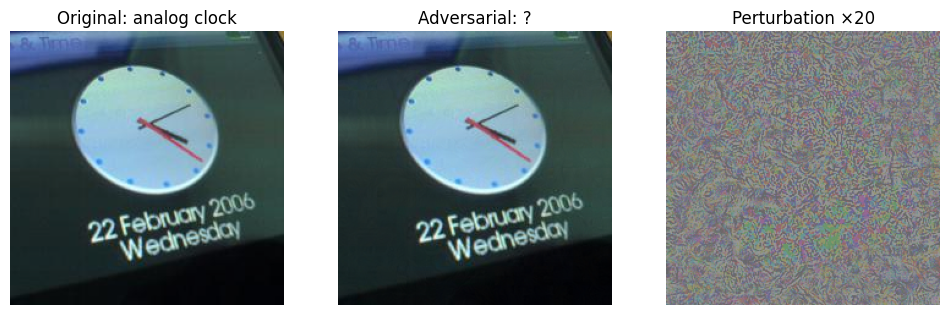

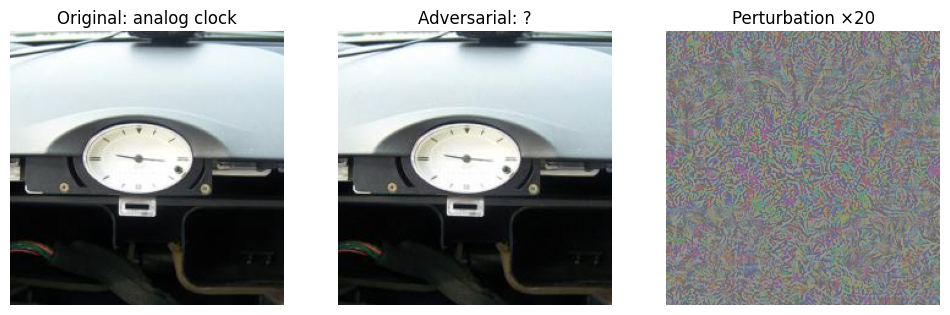

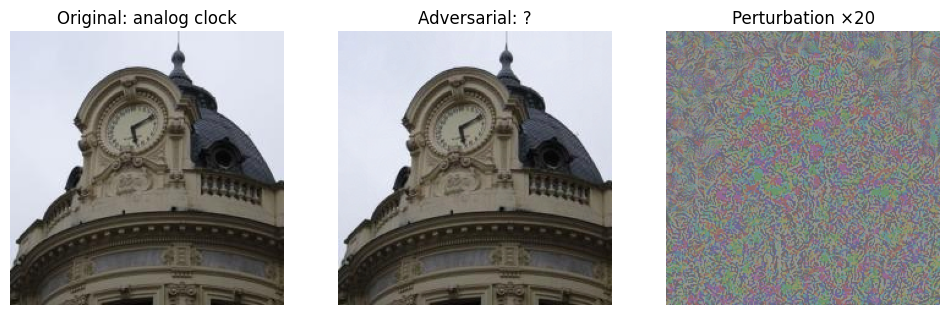

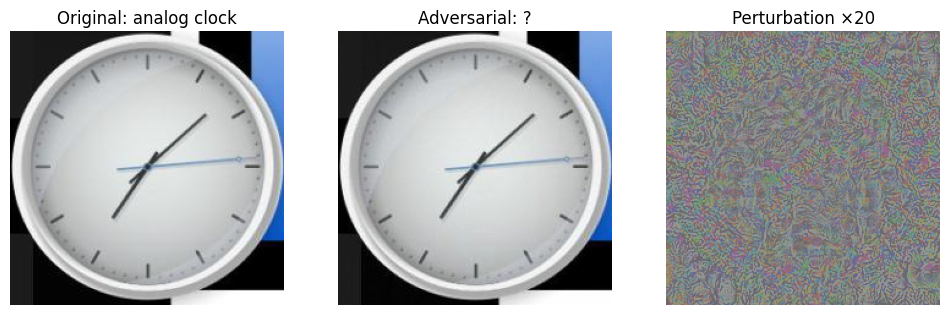

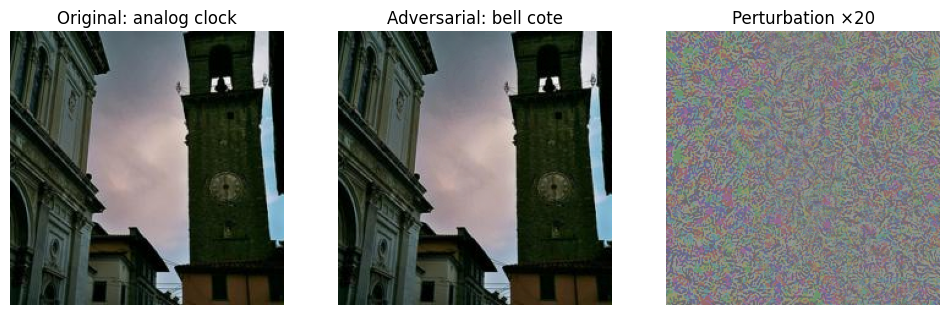

In [21]:
def visualize_pgd_examples(num=5, amplify=20):
    model.eval()
    count = 0
    for i in range(len(adv_images_pgd_tensor)):
        orig_norm = test_dataset[i][0]  # already normalized
        adv_norm = adv_images_pgd_tensor[i]

        orig = denormalize(orig_norm).permute(1, 2, 0).numpy()
        adv = denormalize(adv_norm).permute(1, 2, 0).numpy()
        perturbation = adv - orig

        image_tensor = adv_norm.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = output.max(1)

        pred_label = idx_to_label.get(predicted.item(), "?")
        true_label = idx_to_label.get(adv_labels_pgd_tensor[i].item(), "?")

        if pred_label != true_label:
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(np.clip(orig, 0, 1))
            plt.title(f"Original: {true_label}")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(np.clip(adv, 0, 1))
            plt.title(f"Adversarial: {pred_label}")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            pert_vis = np.clip((perturbation * amplify + 0.5), 0, 1)  # center at 0.5
            plt.imshow(pert_vis)
            plt.title(f"Perturbation ×{amplify}")
            plt.axis('off')

            plt.show()

            count += 1
            if count >= num:
                break
visualize_pgd_examples()

### Task 4: Patch attacks

In [22]:
def patch_pgd_attack(model, images, labels, epsilon, alpha, iters, patch_size):
    B, C, H, W = images.size()
    ori_images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    adv_images = ori_images.clone().detach()

    # Center patch coordinates
    t = (H - patch_size) // 2
    l = (W - patch_size) // 2
    top = torch.full((B,), t, dtype=torch.long)
    left = torch.full((B,), l, dtype=torch.long)

    for _ in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = adv_images.grad.data

        updated_images = adv_images.clone().detach()

        for i in range(B):
            t, l = top[i], left[i]
            patch = adv_images[i, :, t:t+patch_size, l:l+patch_size]
            patch_grad = grad[i, :, t:t+patch_size, l:l+patch_size]

            # Update the patch and do the projection
            adv_patch = patch + alpha * patch_grad.sign()
            perturb = torch.clamp(adv_patch - ori_images[i, :, t:t+patch_size, l:l+patch_size],
                                  min=-epsilon, max=epsilon)
            new_patch = ori_images[i, :, t:t+patch_size, l:l+patch_size] + perturb
            updated_images[i, :, t:t+patch_size, l:l+patch_size] = new_patch.detach()

        adv_images = updated_images.clone().detach()

    return adv_images

In [23]:
# Patch PGD Parameters
epsilon_3 = 0.5
alpha = 0.04
iters = 100
patch_size = 32

adv_images_patch = []
adv_labels_patch = []

model.eval()
total, correct_top1, correct_top5 = 0, 0, 0

In [24]:
start = time.time()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Patch PGD attack
    patched = patch_pgd_attack(model, images, labels, epsilon_3, alpha, iters, patch_size)

    # Save perturbed images with labels
    adv_images_patch.append(patched.detach().cpu())
    adv_labels_patch.append(labels.detach().cpu())

    # Evaluation
    outputs = model(patched)
    _, pred = outputs.topk(5, 1, True, True)
    correct = pred.eq(labels.view(-1, 1).expand_as(pred))
    correct_top1 += correct[:, :1].sum().item()
    correct_top5 += correct[:, :5].sum().item()
    total += labels.size(0)

end = time.time()
# Accuracy
patch_top1 = correct_top1 / total
patch_top5 = correct_top5 / total

print(f"Patch Attack took {end - start:.2f} seconds")
print(f"Patch Attack Top-1 Accuracy: {patch_top1:.4f}")
print(f"Patch Attack Top-5 Accuracy: {patch_top5:.4f}")

Patch Attack took 266.11 seconds
Patch Attack Top-1 Accuracy: 0.1140
Patch Attack Top-5 Accuracy: 0.4820


In [25]:
adv_images_patch_tensor = torch.cat(adv_images_patch, dim=0)
adv_labels_patch_tensor = torch.cat(adv_labels_patch, dim=0)
print(f"Generated {len(adv_images_patch_tensor)} patch adversarial examples.")

Generated 500 patch adversarial examples.


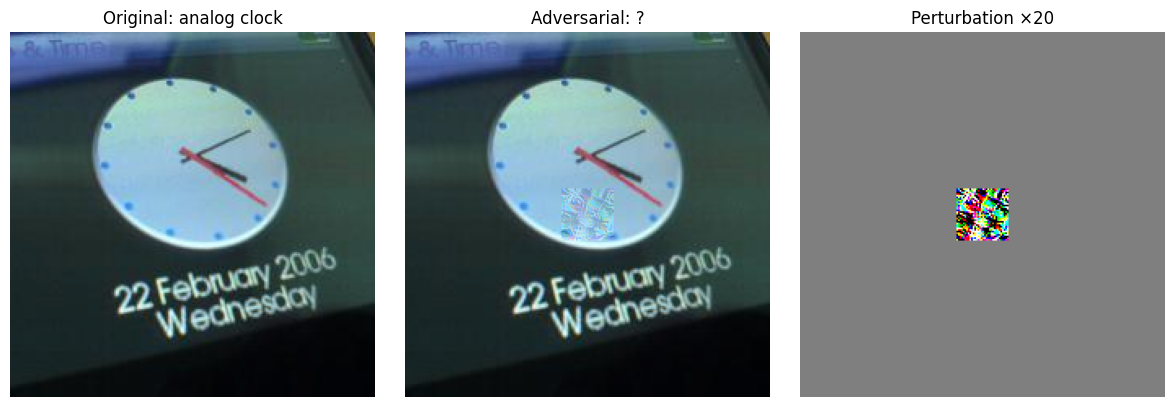

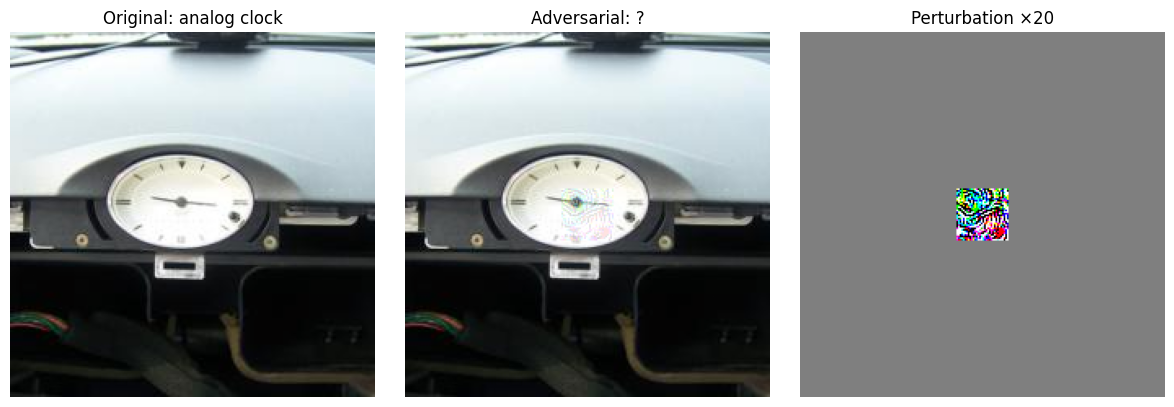

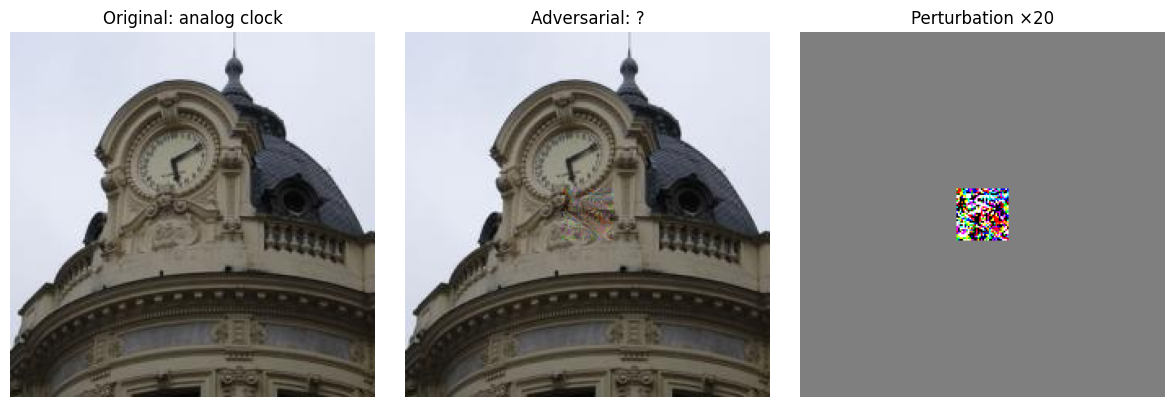

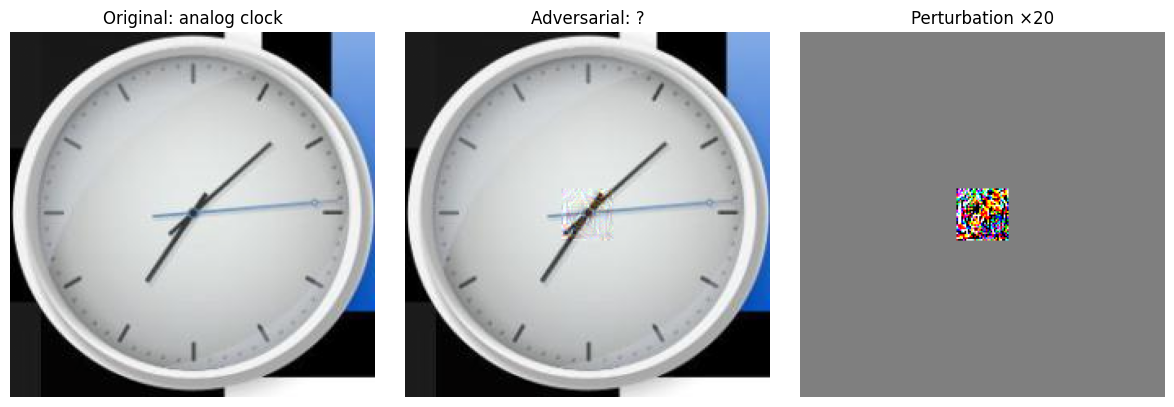

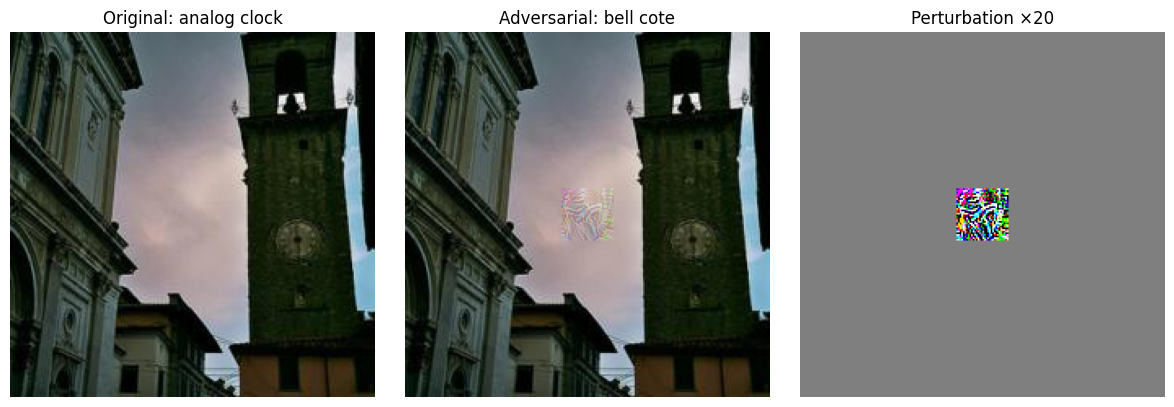

In [26]:
def visualize_patch_attack(num=5, amplify=20):
    model.eval()
    count = 0
    for i in range(len(adv_images_patch_tensor)):
        # Get the original image & the image against it (both normalized)
        orig_norm = test_dataset[i][0]
        adv_norm = adv_images_patch_tensor[i]

        # Inverse normalization for visualization
        orig = denormalize(orig_norm).permute(1, 2, 0).numpy()
        adv = denormalize(adv_norm).permute(1, 2, 0).numpy()
        perturbation = adv - orig

        image_tensor = adv_norm.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = output.max(1)

        pred_label = idx_to_label.get(predicted.item(), "?")
        true_label = idx_to_label.get(adv_labels_patch_tensor[i].item(), "?")

        if pred_label != true_label:
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(np.clip(orig, 0, 1))
            plt.title(f"Original: {true_label}")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(np.clip(adv, 0, 1))
            plt.title(f"Adversarial: {pred_label}")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            pert_vis = np.clip((perturbation * amplify + 0.5), 0, 1)
            plt.imshow(pert_vis)
            plt.title(f"Perturbation ×{amplify}")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            count += 1
            if count >= num:
                break
visualize_patch_attack(num=5, amplify=20)

### Task 5: Transferring attacks

In [27]:
import torchvision.models as models

# Load DenseNet-121 pretrained on ImageNet-1K
new_model = models.densenet121(weights='IMAGENET1K_V1').to(device)
new_model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 202MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [28]:
# Evaluate top-1 and top-5 accuracy
def evaluate_model(model, images_tensor, labels_tensor):
    model.eval()
    total, correct_top1, correct_top5 = 0, 0, 0

    with torch.no_grad():
        for i in range(0, len(images_tensor), 32):
            batch_images = images_tensor[i:i+32].to(device)
            batch_labels = labels_tensor[i:i+32].to(device)

            outputs = model(batch_images)
            _, pred = outputs.topk(5, 1, True, True)
            correct = pred.eq(batch_labels.view(-1, 1).expand_as(pred))

            correct_top1 += correct[:, :1].sum().item()
            correct_top5 += correct[:, :5].sum().item()
            total += batch_labels.size(0)

    return correct_top1 / total, correct_top5 / total

In [29]:
# Original test set
orig_images_tensor = torch.stack([x[0] for x in test_dataset])
orig_labels_tensor = torch.tensor([x[1] for x in test_dataset])

# FGSM
adv1_images = adv_images_tensor
adv1_labels = adv_labels_tensor

# PGD
adv2_images = adv_images_pgd_tensor
adv2_labels = adv_labels_pgd_tensor

# Patch
adv3_images = adv_images_patch_tensor
adv3_labels = adv_labels_patch_tensor

In [30]:
# Original
orig_top1, orig_top5 = evaluate_model(new_model, orig_images_tensor, orig_labels_tensor)
print(f" DenseNet-121 - Original: Top-1={orig_top1:.4f}, Top-5={orig_top5:.4f}")

# FGSM
adv1_top1, adv1_top5 = evaluate_model(new_model, adv1_images, adv1_labels)
print(f" DenseNet-121 - FGSM:     Top-1={adv1_top1:.4f}, Top-5={adv1_top5:.4f}")

# PGD
adv2_top1, adv2_top5 = evaluate_model(new_model, adv2_images, adv2_labels)
print(f" DenseNet-121 - PGD:      Top-1={adv2_top1:.4f}, Top-5={adv2_top5:.4f}")

# Patch
adv3_top1, adv3_top5 = evaluate_model(new_model, adv3_images, adv3_labels)
print(f" DenseNet-121 - Patch:    Top-1={adv3_top1:.4f}, Top-5={adv3_top5:.4f}")

 DenseNet-121 - Original: Top-1=0.7440, Top-5=0.9280
 DenseNet-121 - FGSM:     Top-1=0.6280, Top-5=0.8860
 DenseNet-121 - PGD:      Top-1=0.6320, Top-5=0.9000
 DenseNet-121 - Patch:    Top-1=0.6980, Top-5=0.9080
